In [1]:
import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self, plot_interval=1, evaluate_interval=10, x_val=None, y_val_categorical=None):
        self.plot_interval = plot_interval
        self.evaluate_interval = evaluate_interval
        self.x_val = x_val
        self.y_val_categorical = y_val_categorical
        #self.model = model
    
    def on_train_begin(self, logs={}):
        print('Begin training')
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        if self.evaluate_interval is None:
            self.logs.append(logs)
            self.x.append(self.i)
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.acc.append(logs.get('acc'))
            self.val_acc.append(logs.get('val_acc'))
            self.i += 1
        
        if (epoch%self.plot_interval==0):
            clear_output(wait=True)
            f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20,5))
            ax1.plot(self.x, self.losses, label="loss")
            ax1.plot(self.x, self.val_losses, label="val_loss")
            ax1.legend()

            ax2.plot(self.x, self.acc, label="acc")
            ax2.plot(self.x, self.val_acc, label="val_acc")
            ax2.legend()
            plt.show();
        #score = self.model.evaluate(x_test, y_test_categorical, verbose=0)
        
        #print("accuracy: ", score[1])
    
    def on_batch_end(self, batch, logs={}):
        if self.evaluate_interval is not None:
            if (batch%self.evaluate_interval==0):
                self.i += 1
                self.logs.append(logs)
                self.x.append(self.i)
                self.losses.append(logs.get('loss'))
                self.acc.append(logs.get('acc'))

                if self.x_val is not None:
                    score = self.model.evaluate(self.x_val, self.y_val_categorical, verbose=0)
                    self.val_losses.append(score[0])
                    self.val_acc.append(score[1])

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

# Cargo datos

In [3]:
folder = 'C:/Users/Lenovo/Documents/GitHub/Datasets/Kaggle - Imagenes - MNIST/'
x = np.load(folder+'train_images.npy')
y = np.loadtxt(folder+'train_labels.csv', delimiter=',', skiprows=1)
x_test = np.load(folder+'test_images.npy')

In [4]:
print("x shape:{}".format(x.shape))
print("y shape:{}".format(y.shape))
print("x_test shape:{}".format(x_test.shape))

x shape:(60000, 28, 28)
y shape:(60000,)
x_test shape:(10000, 28, 28)


In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

In [6]:
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers

In [7]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

# Red neuronal básica

In [8]:
output_size = 10

dropout_rate  = 0.25

default_initializer = initializers.normal(mean=0, stddev=0.010)

# Creo el modelo
model_single_layer = Sequential()
model_single_layer.add(Flatten(input_shape=x_train.shape[1:]))

model_single_layer.add(Dense(1024, kernel_initializer=default_initializer, name='Capa_Oculta_1'))
model_single_layer.add(BatchNormalization())
model_single_layer.add(Activation('relu'))
model_single_layer.add(Dropout(dropout_rate))

model_single_layer.add(Dense(512, kernel_initializer=default_initializer, name='Capa_Oculta_2'))
model_single_layer.add(BatchNormalization())
model_single_layer.add(Activation('relu'))
model_single_layer.add(Dropout(dropout_rate))

model_single_layer.add(Dense(256, kernel_initializer=default_initializer, name='Capa_Oculta_3'))
model_single_layer.add(BatchNormalization())
model_single_layer.add(Activation('relu'))
model_single_layer.add(Dropout(dropout_rate))

model_single_layer.add(Dense(128, kernel_initializer=default_initializer, name='Capa_Oculta_4'))
model_single_layer.add(BatchNormalization())
model_single_layer.add(Activation('relu'))
model_single_layer.add(Dropout(dropout_rate))

model_single_layer.add(Dense(output_size, kernel_initializer=default_initializer, name='Output'))
model_single_layer.add(Activation('softmax'))
model_single_layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
Capa_Oculta_1 (Dense)        (None, 1024)              803840    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
Capa_Oculta_2 (Dense)        (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
__________

In [9]:
# Compilo el modelo
lr = 0.0001 

ADAM = optimizers.Adam(lr=lr)

model_single_layer.compile(loss = 'categorical_crossentropy', optimizer=ADAM, metrics=['accuracy'])

In [10]:
# Callbacks

## Callback para graficar
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=60, x_val=x_valid, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='single-layer.mnist.hdf5', verbose=1, save_best_only=True)

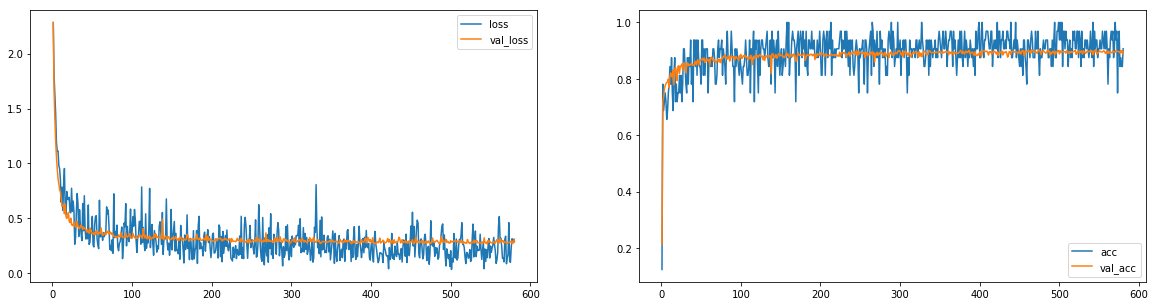


Epoch 00020: val_loss did not improve


In [11]:
batch_size = 1024
model_single_layer.fit(x_train, 
                       y_train_categorical,
                       epochs=20, 
                       validation_data = (x_valid, y_val_categorical),
                       callbacks=[plot_losses, checkpointer],
                      )

In [12]:
loss, acc = model_single_layer.evaluate(x_valid, y_val_categorical)

6000/6000 [==============================] - 2s 310us/step


In [13]:
print(acc)

0.8951666666666667


In [14]:
test_prediction = model_single_layer.predict(x_test)

In [15]:
test_labels = np.argmax(test_prediction, axis = 1)

In [16]:
import pandas
df = pandas.DataFrame(data={"Category": test_labels}).astype(int)
df.to_csv("C:/Users/Lenovo/Documents/GitHub/Lab_ML_ITBA/multiclass/submission.csv", sep=',',index=True,  index_label='Id')